# Introduction
This document represents solving classification problem of PDFs. For source of documents was choosed [Customer Release Notes](documentation.extremenetworks.com). 

The main stages:


*   Collecting PDFs from source and gathering screenshots of title pages with [Selenium Automated Browser](https://pypi.org/project/selenium/)
*   Manual classifying data for Supervised learning of [CNN](https://www.tensorflow.org/tutorials/images/cnn).
*   Preparing images with using [PIL](https://pillow.readthedocs.io/en/stable/).
*   Loading datasets and training of models (supervised and unsupervised).



# Data collecting and preparing

Data gathering was no implemented in Google Collab and will represented in peaces of code.

Here is function to geting screenshot of document in browser (headless mode is turned off):

```
def get_screen(pdf: str,fullpath: str):
    """
    Gathers image of a title page of PDF
    :param pdf: filename with .PDF extension
    :param fullpath: full way to PDF
    :return: None
    """
    crd = ChromeDriver()
    if pdf.replace('.pdf','.png') in os.listdir(
            os.path.join(os.getcwd(), "train_data",
                         "documentation.extremenetworks.com")
    ): return None
    crd.create_driver()
    crd.get_url('file:///D:/PyProjects/extremeportal/'+fullpath.replace('./','')+'/'+pdf)
    time.sleep(1.5)
    try:
        crd.screenshot(pdf.replace('.pdf','.png'))
    except:
        pass
    crd.quit()
```

ChromeDriver Class:

```
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys

class ChromeDriver:
    _screenshot_folder = os.path.join(
            os.getcwd(),
            "tmp",
            "screenshots")
    _chrome_driver = os.path.join(os.getcwd(),
                                     "chromedriver.exe")
    _chrome_options = webdriver.ChromeOptions()
    _chrome_options.binary_location = "C:\Program Files\Google\Chrome\Application\chrome.exe"
    _chrome_options.add_argument("--disable-dev-shm-using")
    _chrome_options.add_argument("--no-sandbox")
    _chrome_options.add_argument('ignore-certificate-errors')
    _chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    _chrome_options.add_experimental_option('useAutomationExtension', False)
    _chrome_options.add_argument("--disable-blink-features=AutomationControlled")

    def __init__(self):
        self.headers = {
            'Accept': 'application/json',
            'Accept-Language': 'ru-ru,ru;q=0.8,en-us;q=0.5,en;q=0.3',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'DNT': '1'
        }

    def screenshot(self, file_name) -> None:
        original_size = self.driver.get_window_size()
        required_width = self.driver.execute_script('return document.body.parentNode.scrollWidth')
        required_height = self.driver.execute_script('return document.body.parentNode.scrollHeight')
        self.driver.set_window_size(required_width, required_height)
        self.find_elements_by_xpath("/html/body/embed")[0].screenshot(ChromeDriver._screenshot_folder+'/'+file_name)
        self.driver.set_window_size(original_size['width'], original_size['height'])

    def find_elements_by_xpath(self, xpath):
        """Function for searching elements with XPATH expression"""
        return self.driver.find_elements(By.XPATH, xpath)

    def create_driver(self, proxy = False):
        if not getattr(self, 'driver', None):

            self.driver = webdriver.Chrome(executable_path=ChromeDriver._chrome_driver,
                                      chrome_options=ChromeDriver._chrome_options)

            self.driver.header_overrides = self.headers
            """Here I defined window size:"""
            self.driver.set_window_size(1024, 1024)
            ChromeDriver._logger.info('Chrome Driver started.')
        return self.driver
```

*Here is not full code of class*. I skipped functions and settings which are not important for gathering screenshot of document from local folder but previously I used ChromeDriver to collect data directly from the source.

### Data preparation with PIL

After manual classifying images, I recived 20 classes of documents. 
First of all, I loaded data to array, then I done one hot transformation for labels. For preparing X dataset (images) i used:


*   PIL Box Blur (2)
*   Cropping
*   PIL Contrast Enhance
*   PIL Sharpness and one more contrast



```
def load_data(path = r'.\tmp\screenshots'):
    X = []
    X_names = []
    # _X = []
    Y = []
    for _class in range(0,20):
        files = os.listdir(path+'\\'+str(_class))
        Y.extend([_class for i in range(len(files))])
        # _X.extend([Image.open(path+'\\'+str(_class)+'\\'+file) for file in files])
        X.extend([Image.open(path+'\\'+str(_class)+'\\'+file) for file in files])
        X_names.extend(files)
        # X.extend([np.array(x) for x in _X])
    return X_names, X, Y

def transform_data(X,Y):
    import sklearn.preprocessing
    old_labels = Y
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(range(max(Y) + 1))
    Y = label_binarizer.transform(Y)
    #converting X
    test_im = X[random.randint(0,len(Y))]
    label = old_labels[random.randint(0,len(Y))]

    def im_show(test_im, label):
        plt.figure()
        plt.title('Label for represented data: %i' % label)
        plt.axis("off")
        plt.imshow(np.array(test_im), cmap='Greys', interpolation='nearest')
        plt.show()

    def transform_X(im):
        im = im.filter(ImageFilter.BoxBlur(2))
        im = im.crop((305, 59, 982, 691))
        filterr = ImageEnhance.Contrast(im)
        im = filterr.enhance(3)
        filterr = ImageEnhance.Sharpness(test_im)
        im = filterr.enhance(20)
        filterr = ImageEnhance.Contrast(test_im)
        im = filterr.enhance(3)
        im = im.resize([100 for s in im.size])
        im = ImageOps.grayscale(im)
        return im

    im_show(test_im, label)
    im_show(transform_X(test_im), label)

    X = np.array([np.array(transform_X(x)) for x in X])/ 255.0

    return X, Y
```






### Loading datasets

It this cells I would load datasets prepared on my local machine.

In [ ]:
# !rm pdf_labels.txt
# !rm X.npy
# !rm Y.npy
!ls
from google.colab import files
uploaded = files.upload()

sample_data


Saving pdf_labels.txt to pdf_labels.txt
Saving X_100.npy to X_100.npy
Saving Y_100.npy to Y_100.npy


In [ ]:
!ls

pdf_labels.txt	sample_data  X_100.npy	Y_100.npy


Importing libraries

In [ ]:
from tensorflow.keras import datasets, layers, models, optimizers, losses, Sequential
import tensorflow as  tf
from sklearn.model_selection import KFold
from sklearn import metrics
# !pip uninstall matplotlib
!pip install matplotlib==3.1.3 seaborn --upgrade --quiet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

     |████████████████████████████████| 13.1 MB 29.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
def convert_data(xdataset: np.ndarray) -> np.ndarray:
  xdataset=xdataset/255
  return xdataset.reshape(xdataset.shape[0], 100, 100, 1)

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # tick_marks = np.arange(len(names))
    # plt.xticks(tick_marks, names, rotation=90)
    # plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
import pandas as pd

def  report(y_test, y_pred, model_name='Model', clusters=24):
    y_test = np.argmax(y_test, axis=1)
    try:
      y_pred = np.argmax(y_pred, axis=1)
    except:
      pass

    f1 = metrics.f1_score(y_test, y_pred, average= "weighted")
    accuracy = metrics.accuracy_score(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test, y_pred)
    print("-----------------Report---------------")
    print("F1 score: {}".format(f1))
    print("Accuracy score: {}".format(accuracy))
    print("Confusion matrix: \n", cm)
    print('Plotting confusion matrix')

    plt.figure()
    plot_confusion_matrix(cm, list(map(str, list(range(clusters)))))
    plt.show()

    print(metrics.classification_report(y_test, y_pred))

Loading data and doing test-train split.

In [ ]:
import numpy as np
from numpy import load
X_labels = open('pdf_labels.txt').read().split('\n')
X, Y = load('X_100.npy'), load('Y_100.npy')
rng_state = np.random.get_state()
np.random.shuffle(X_labels)
np.random.set_state(rng_state)
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(Y)
print(f"X: {np.array(X).shape}, Y: {np.array(Y).shape}")
x_train, x_test = X[:400], X[400:]
y_train, y_test = Y[:400], Y[400:]

X: (555, 100, 100), Y: (555, 20)


Let's check our dataset images:

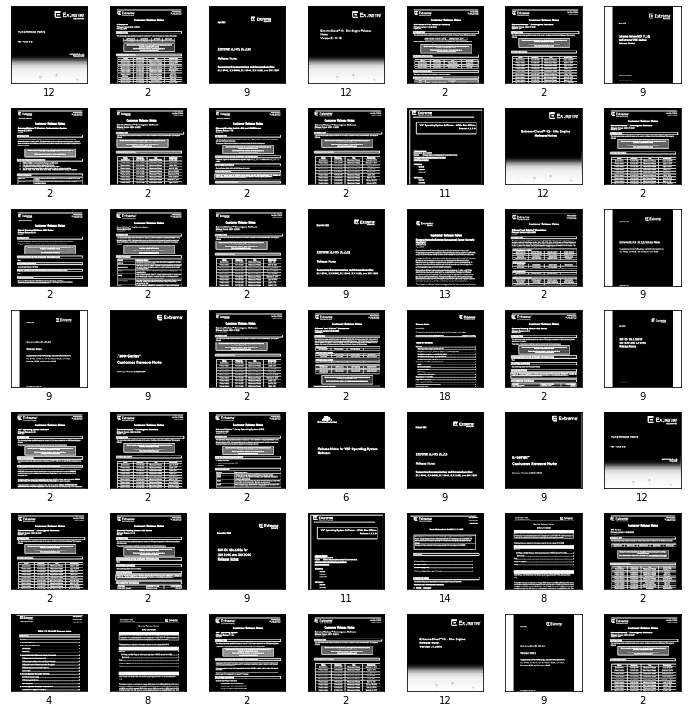

In [ ]:
import random
ROW = 7
COLUMN = 7
plt.figure(figsize=(10, 10)) 
for i in range(ROW * COLUMN):
  plt.subplot(ROW, COLUMN, i+1) 
  j = random.randint(0,400)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(str(y_train.argmax(axis=1)[j]))
  plt.imshow(x_train[j], cmap='Greys',  interpolation='nearest')
  plt.tight_layout() 
plt.show()

-----------------Report---------------
F1 score: 1.0
Accuracy score: 1.0
Confusion matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 173   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0  18   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0  13   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   9   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0  12   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0  79   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0   0   0

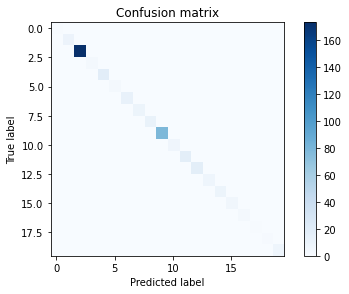

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00       173
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        79
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        17
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         3
          17       1.00    

In [ ]:
#testing helper function and show train data 
report(y_train, y_train, 'test', clusters=20)

# Training of models

####Supervised training & CNN

In [ ]:
class CNN_classificator():
  def __init__(self, x_train, y_train, x_test, y_test, n_folds):
      self.x_train = (x_train).reshape(x_train.shape[0], 100, 100, 1)
      self.y_train = y_train
      self.x_test = (x_test).reshape(x_test.shape[0], 100, 100, 1)
      self.y_test = y_test
      self.n_folds = n_folds
      self.scores = []
      self.histories = []
      self.models = []
      self.final_model = None

  def initialize_model(self, summaryEnabled=False):
      model = Sequential()
      # model.add(layers.BatchNormalization())
      model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 1)))
      model.add(layers.MaxPooling2D((2,2),(2,2)))
      model.add(layers.Dropout(0.25))
      model.add(layers.Flatten())
      model.add(layers.Dense(units=128, activation = 'relu'))
      model.add(layers.Dense(units=20, activation = 'softmax'))

      if summaryEnabled == True: model.summary()
      return model
  def info(self):
    model = self.initialize_model(True)
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

  def fit(self, epochs):
      kfold = KFold(self.n_folds, shuffle=True, random_state=1)
      for i_trainX, i_testX in kfold.split(self.x_train):
          model = self.initialize_model()
          opt = optimizers.Adam()
          # opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)
          model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
          history = model.fit(self.x_train[i_trainX], self.y_train[i_trainX], epochs=epochs,
                              validation_data=(self.x_train[i_testX], self.y_train[i_testX]))
          self.histories.append(history)
          self.models.append(model)
          _, acc = model.evaluate(self.x_test, self.y_test, verbose=0)
          self.scores.append(acc)
          print('> %.3f' % (acc * 100.0))

  def predict(self):
      if self.final_model == None:
          self.final_model = self.models[self.scores.index(max(self.scores))]
      y_pred = self.final_model.predict(self.x_test)
      return y_pred

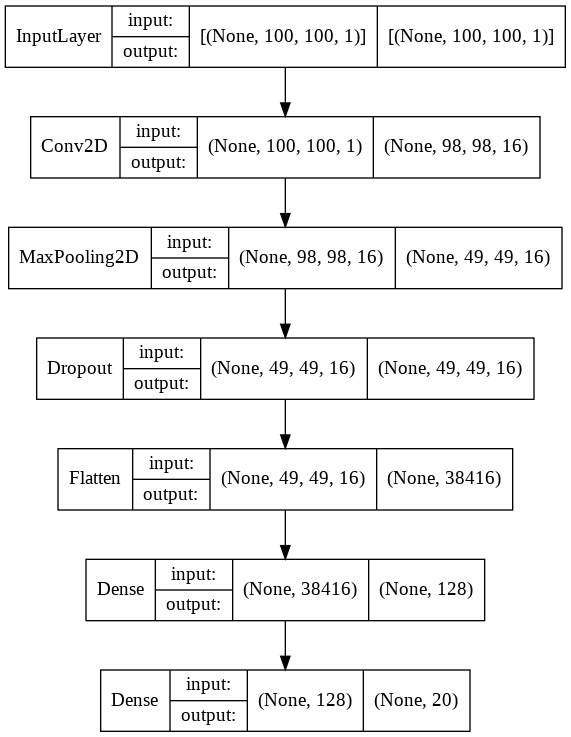

In [ ]:
from IPython.display import Image
tf.keras.utils.plot_model(cnn.initialize_model(), to_file='model.png', show_shapes=True, show_layer_names=False)
Image('model.png')

In [ ]:
cnn = CNN_classificator(x_train, y_train, x_test, y_test, n_folds = 3)
cnn.info()
cnn.fit(epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 16)        0         
                                                                 
 flatten (Flatten)           (None, 38416)             0         
                                                                 
 dense (Dense)               (None, 128)               4917376   
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                        

(155, 20) (155, 20)
-----------------Report---------------
F1 score: 0.9570862660696606
Accuracy score: 0.967741935483871
Confusion matrix: 
 [[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  

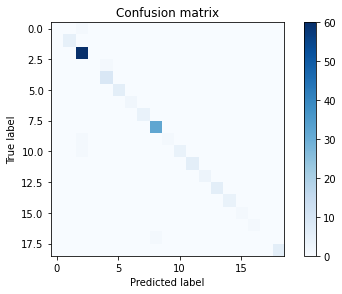

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         5
           2       0.95      1.00      0.98        60
           3       0.00      0.00      0.00         1
           4       0.90      1.00      0.95         9
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       0.97      1.00      0.98        32
          10       1.00      0.50      0.67         2
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          18       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# cnn.x_test = x_test
y_pred = cnn.predict()

print(y_test.shape, y_pred.shape)
report(y_test, y_pred, model_name='Model')


{'conv2d_2': <keras.layers.convolutional.Conv2D object at 0x7f2131853f90>, 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D object at 0x7f21317f1f10>, 'dropout_2': <keras.layers.core.dropout.Dropout object at 0x7f2131f6ff50>, 'flatten_2': <keras.layers.core.flatten.Flatten object at 0x7f21318aded0>, 'dense_4': <keras.layers.core.dense.Dense object at 0x7f213220dc50>, 'dense_5': <keras.layers.core.dense.Dense object at 0x7f21318bde90>}


IndexError: ignored

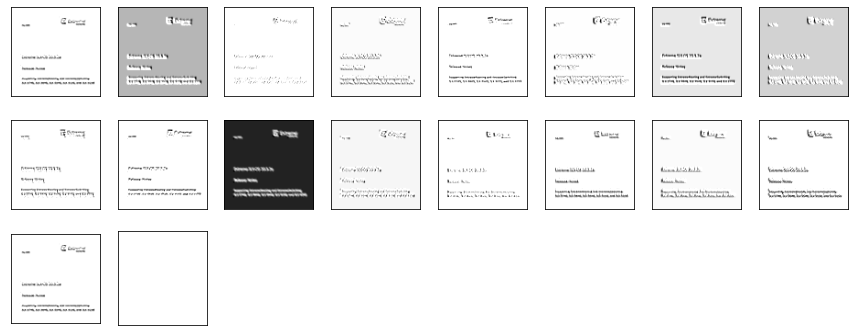

In [ ]:
# Here I want check how looks convolutional layer. 
layer_dict = {layer.name : layer for layer in cnn.final_model.layers}
layer_name = 'conv2d'
print(layer_dict)
modelslice = tf.keras.Model(inputs=cnn.final_model.inputs, outputs=layer_dict[layer_name].output)
image = x_train[10] 
image = np.expand_dims(image, axis=0)
feature_maps = modelslice.predict(image)
plt.figure(figsize=(15, 8))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0, :, :, i-1], cmap=plt.cm.binary)

###Unsuperviser training & KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
class KNN_binary_classificator():
  def __init__(self, x_train, y_train, x_test, y_test, n_folds):
    # self.x_train = np.array([value.ravel() for value in x_train])
    self.x_train = x_train
    self.y_train =y_train.argmax(axis=1)
    # self.x_test = np.array([value.ravel() for value in x_test])
    self.x_test = x_test
    self.y_test = y_test.argmax(axis=1)
    self.n_folds = n_folds
    self.scores = []
    self.models = []
    self.final_model = None

  def initialize_model(self):
    model = KNeighborsClassifier(n_neighbors=25)
    return model

  def fit(self):
    subset_size = len(self.x_train)//self.n_folds
    for i in range(1,self.n_folds):
      model = self.initialize_model()
      model.fit(self.x_train[(i-1)*subset_size:i*subset_size], self.y_train[(i-1)*subset_size:i*subset_size])
      y_pred = model.predict(self.x_test)
      acc = accuracy_score(self.y_test, y_pred)
      print('> %.3f' %acc)
      self.scores.append(acc)
      self.models.append(model)

  def predict(self):
    if self.final_model == None:
      self.final_model = self.models[self.scores.index(max(self.scores))]
    y_pred = self.final_model.predict_proba(self.x_test)
    return y_pred

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=50)
x_train_new=pca.fit_transform(np.array([value.ravel() for value in x_train/255]))
x_test_new=pca.transform(np.array([value.ravel() for value in x_test/255]))
x_train_flat=np.array([value.ravel() for value in x_train/255])
x_test_flat=np.array([value.ravel() for value in x_test/255])

-----------------Report---------------
F1 score: 0.6810634720470786
Accuracy score: 0.6709677419354839
Confusion matrix: 
 [[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0

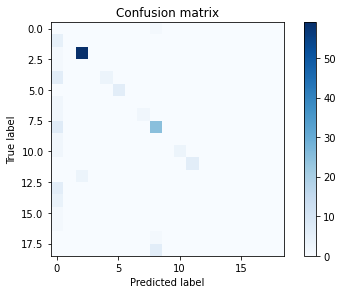

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.95      0.98      0.97        60
           3       0.00      0.00      0.00         1
           4       1.00      0.33      0.50         9
           6       1.00      1.00      1.00         6
           7       0.00      0.00      0.00         2
           8       1.00      0.50      0.67         4
           9       0.76      0.78      0.77        32
          10       0.00      0.00      0.00         2
          11       1.00      0.60      0.75         5
          12       1.00      1.00      1.00         6
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x_train_new, y_train)
y_pred_knn = knn.predict(x_test_new)
report(y_test, y_pred_knn, 'KNearest')

# Saving trained model

In [ ]:
!pip install pyyaml h5py

model_json = cnn.final_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

cnn.final_model.save_weights("model.h5")
print("Saved model to disk")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Saved model to disk


In [ ]:
!ls

model.h5    model.png	    sample_data  Y_100.npy
model.json  pdf_labels.txt  X_100.npy
